/*
Modified version of https://github.com/fort-lexington/deep-learn-bio-nlp repository. Training corpus used from https://github.com/spyysalo/bc2gm-corpus. 
*/

# BioCreative II Gene Mention (GM) Task

For more information: https://biocreative.bioinformatics.udel.edu/tasks/biocreative-ii/task-1a-gene-mention-tagging/

## Training Data

The training data is described in the corpus README.GM file, but I'll describe it here as well. Training data consists of a sentences file `train.in` and a label file `GENE.eval`. The eval file lists the offsets of any gene mentions (there may be none for any sentence). It is easiest to understand using an example using the first sentence from `train.in`:

```
P00001606T0076 Comparison with alkaline phosphatases and 5-nucleotidase
```
Each line contains a single sentence, starting with a unique sentence identifier, followed by the text. This particular sample contains two (2) gene mentions, listed on two lines in the `GENE.eval` file:

```
P00001606T0076|14 33|alkaline phosphatases
P00001606T0076|37 50|5-nucleotidase
```
The first field (delimited by the bar symbols) is the matching sentence ID. The second field contains the offset of the first and last characters in the GM, _not counting space characters_. So, looking at _alkaline phosphatases_, the first letter `a` is at offset 14 keeping in mind that the first character in the sentence is offset 0. If you are not careful, you may think the offset of `a` is 16, but remember that spaces are not counted. Counting in a similar way, the last `s` in _phosphatases_ is at offset 33.

## Prepare the training data

This format is not very convenient for training our ML model. One method used to train NER systems is to label each sentence token with either 'B','I', or 'O' where 'B' marks the beginning token in an entity, 'I' marks subsequent tokens in a multi-token entity (*inside*), and 'O' is for tokens *outside* the entity. For this example, we will use a Keras model to perform _sequence tagging_, where the tags are 'B', 'I', and 'O'. This is very similar to how one would perform full NER or POS tagging.

The module *bc2reader.py* is provided to help convert these two files to something more usable. The first argument to the `BC2Reader` contructor is the sentence file. The second is the gene mention file.


In [1]:
from bc2reader import BC2Reader
import os 

In [2]:
train_home = '/Users/Arushi/Desktop/twoXAR/bc2gm-corpus-master/original-data/train'
reader = BC2Reader('{0}/train.in'.format(train_home), '{0}/GENE.eval'.format(train_home))

In [3]:
reader.convert('{0}/train.json'.format(train_home))
# vocab = [a for a, b in reader.vocab.items() if b >= 3] # Let's see the word at least 3 times
vocab = [a for a, _ in reader.vocab.items()]

In [4]:
print("Size of vocabulary: {0}".format(len(vocab)))

Size of vocabulary: 36638


This will generate a JSON file with a more familiar format. Here is the first sentence in our BIO format:

In [5]:
import json
with open('{0}/train.json'.format(train_home), 'r') as json_file:
    training_data = json.load(json_file)
    print(training_data[0])

['P00001606T0076', ['Comparison', 'with', 'alkaline', 'phosphatases', 'and', '5-nucleotidase'], ['O', 'O', 'B', 'I', 'O', 'B']]


This may be easier to read if we zip together the tokens and labels:

In [6]:
print(list(zip(training_data[0][1], training_data[0][2])))

[('Comparison', 'O'), ('with', 'O'), ('alkaline', 'B'), ('phosphatases', 'I'), ('and', 'O'), ('5-nucleotidase', 'B')]


## Prepare the test data

The same _bc2reader_ is used to format the test file.

In [7]:
test_home = '/Users/Arushi/Desktop/twoXAR/bc2gm-corpus-master/original-data/test'
reader = BC2Reader('{0}/test.in'.format(test_home), '{0}/GENE.eval'.format(test_home))
reader.convert('{0}/test.json'.format(test_home))

with open('{0}/test.json'.format(test_home), 'r') as json_file:
    test_data = json.load(json_file)
    print(test_data[0])

['BC2GM000008491', ['Phenotypic', 'analysis', 'demonstrates', 'that', 'trio', 'and', 'Abl', 'cooperate', 'in', 'regulating', 'axon', 'outgrowth', 'in', 'the', 'embryonic', 'central', 'nervous', 'system', '(', 'CNS', ')', '.'], ['O', 'O', 'O', 'O', 'B', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]


## Setup the model constants

In [8]:
import numpy as np
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, GRU, ConvLSTM2D
from keras.layers import TimeDistributed, Dropout, Bidirectional

max_len = 150
lstm_n = 256
batch_n = 25
epoch_n = 3

word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}
word2idx['_PAD_'] = 0
word2idx['_OOV_'] = 1

tag2idx = {'O': 0, 'B': 1, 'I': 2}
n_tags = len(tag2idx)

X = [[word2idx.get(m, 1) for m in row[1]] for row in training_data]
y = [[tag2idx.get(m, 0) for m in row[2]] for row in training_data]

# Get an idea about class dist.
cnt = Counter()
for labels in y:
    cnt.update(labels)
cnt_total = sum([v for _, v in cnt.items()])
for k, v in cnt.items():
    print("{0}: {1}".format(k, (100 * v)/cnt_total))
        

# Get a general idea of the lengths of the sequences:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in X], bins=50)
plt.show()

X_test = [[word2idx.get(m, 1) for m in row[1]] for row in test_data]
y_test = [[tag2idx.get(m, 1) for m in row[2]] for row in test_data]

X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx['_PAD_'])
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=word2idx['_PAD_'])
 
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['O']) 
y = [to_categorical(i, num_classes=n_tags) for i in y]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx['O']) 
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]




Using TensorFlow backend.


0: 90.28657237542905
1: 4.426559356136821
2: 5.286868268434135


<Figure size 640x480 with 1 Axes>

## Prepare the Embeddings (GloVe)

See: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

The embeddings loaded below were learned from PMC Open Access dataset (non-commercial). This collection contains 430,944 journal articles in XML (or text) format. The XML alone is over 50GB uncompressed, so only download if you have plenty of drive space and time. Tables were filtered out since they tended to contain numeric data and not narrative text. The final cleaned text is 1,784,578,876 tokens, and 958,634 lines of text!

This first attempt at using pre-trained embeddings from biomedical journal articles didn't improve the accuracy over learning embeddings directly from the training data, but it is useful to demonstrate how these can be added to the model. Run the code below to load the pre-trained PMC embeddings. You will need to add `weights=[embedding_matrix]` and `trainable=False` as arguments to the model's Embedding layer.

In [10]:
embeddings_dir = r'/Users/Arushi/Desktop/twoXAR/deep-learn-bio-nlp-master/'
embedding_dim = 256

In [ ]:
embeddings_index = {}
with open(os.path.join(embeddings_dir, 'vectors_100K.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word2idx) + 1, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Creating the model

This is the first version of the model using a single Bidirectional LSTM layer. 

In [11]:
# Borrowed heavily from 
# https://appliedmachinelearning.blog/2019/04/01/training-deep-learning-based-named-entity-recognition-from-scratch-disease-extraction-hackathon/
# as a general outline for the model...

_input = Input(shape=(max_len,))
model = Embedding(input_dim=len(word2idx) + 1, 
                  output_dim=embedding_dim, 
                  # weights=[embedding_matrix], 
                  input_length=max_len, 
                  # trainable=False, 
                  mask_zero=True)(_input)
model = Dropout(0.2)(model)
model = Bidirectional(GRU(units=lstm_n, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)
model = Model(_input, out)
 
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 256)          9380096   
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 512)          787968    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 3)            1539      
Total params: 10,169,603
Trainable params: 10,169,603
Non-trainable params: 0
_________________________________________________________________


### Fit the model

In [12]:
history = model.fit(X, np.array(y), batch_size=batch_n, epochs=epoch_n, validation_split=0.05, verbose=1)

/Users/Arushi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14250 samples, validate on 750 samples
Epoch 1/3
14250/14250 [==============================] - 1959s 137ms/step - loss: 0.0341 - categorical_accuracy: 0.9351 - val_loss: 0.0211 - val_categorical_accuracy: 0.9608
Epoch 2/3
14250/14250 [==============================] - 1433s 101ms/step - loss: 0.0142 - categorical_accuracy: 0.9718 - val_loss: 0.0189 - val_categorical_accuracy: 0.9659
Epoch 3/3
14250/14250 [==============================] - 1110s 78ms/step - loss: 0.0080 - categorical_accuracy: 0.9840 - val_loss: 0.0221 - val_categorical_accuracy: 0.9610


### Plot and review the training history

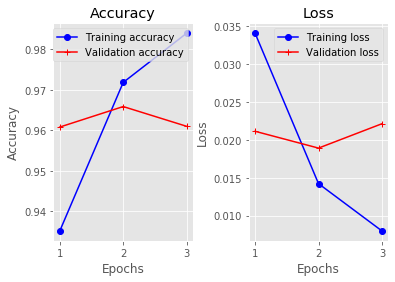

In [13]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r+-', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r+-', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Test set evaluation

In [14]:
pred = model.predict(X_test)
print(pred.shape)
pred_index = np.argmax(pred, axis=-1)
print(pred_index.shape)

(5000, 150, 3)
(5000, 150)


The following code converts the output of the tagger (where each term is BIO tagged) back to the original BCII format.

In [15]:
from collections import defaultdict

with open('{0}/ryan_eval.eval'.format(test_home), 'w') as mention_fh:
    for i, row in enumerate(test_data):
        sent_id = row[0]
        tokens = row[1][:max_len]
        running_count = 0
        buffer = {'s':None, 'e':None, 'text':[]}
        for j, token in enumerate(tokens):
            tag = pred_index[i][j]
            if tag == 1:
                buffer.get('text').append(token)
                buffer['s'] = running_count
                buffer['e'] = running_count + len(token) - 1
            elif tag == 2:
                buffer.get('text').append(token)
                buffer['e'] = running_count + len(token) - 1
            elif tag == 0 and buffer.get('s'):
                text = ' '.join(buffer.get('text'))
                mention_fh.write('{0}|{1} {2}|{3}\n'.format(sent_id, buffer.get('s'), buffer.get('e'), text))
                buffer = {'s':None, 'e':None, 'text':[]}
            running_count += len(token)

Using the BCII evaluation script, initial output on the test data is mixed (note that your output may vary). The precision is in the range of the shared task participants, but the recall leaves something to be desired -- especially the high number of false negatives (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2559986/). 

    TP: 4307
    FP: 1296
    FN: 2024
    Precision: 0.768695341781189 Recall: 0.680303269625652 F: 0.721803251215016

This F score isn't bad, but is also isn't great. 
This score does place this system above the bottom 3 of 19 participants in the 2008 competition. Note that _only_ the training data was used (what the task describes as a _closed_ system), not using any outside resources. This is a good starting point.

In [16]:
file = open('{0}/ryan_eval.eval'.format(test_home), 'r')
lines = file.readlines()

In [17]:
lines

['BC2GM000008491|34 37|trio\n',
 'BC2GM000008491|41 43|Abl\n',
 'BC2GM000019979|56 64|lamina VII\n',
 'BC2GM000019979|70 79|lamina VIII\n',
 'BC2GM000030196|34 43|Hepatitis A\n',
 'BC2GM000030196|59 62|Weng\n',
 'BC2GM000099421|85 94|hemoglobin\n',
 'BC2GM000099421|125 139|etiologic factor\n',
 'BC2GM000136143|3 28|COR biosynthetic gene cluster\n',
 'BC2GM000136143|138 140|COR\n',
 'BC2GM000227172|19 22|MAPK\n',
 'BC2GM000227172|30 34|Raf-1\n',
 'BC2GM000293986|42 51|human gp330\n',
 'BC2GM000360337|77 79|PLC\n',
 'BC2GM000478841|82 86|procollagen PC III\n',
 'BC2GM000487648|46 60|serum pepsinogen\n',
 'BC2GM000493215|3 18|P - ITIM - compelled\n',
 'BC2GM000493215|25 38|phosphoprotein\n',
 'BC2GM000493215|65 69|SHP-2\n',
 'BC2GM000493215|98 101|SHIP\n',
 'BC2GM000493215|105 107|Shc\n',
 'BC2GM000522836|27 50|M1Ach - muscarinic receptor\n',
 'BC2GM000522836|73 76|GnRH\n',
 'BC2GM000522836|114 116|PRL\n',
 'BC2GM000522836|171 179|Gs protein\n',
 'BC2GM000534680|103 110|SMADs 1 - 5\n',
 '

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("/Users/Arushi/Desktop/twoXAR/parsed_mce_simple.tsv", sep = "\t", header = None)
edited_simple = df.drop(columns = [1])
edited_simple.to_csv(r'edited_simple.txt', header=None, index=None, sep=' ')

In [51]:
import json
import spacy
from collections import Counter, defaultdict
import spacy as nlp
import logging

class BC2Reader_edited(object):

    def __init__(self, train_in):
        self.train_in = train_in
        self.nlplib = spacy.load('en')
        self.vocab = Counter()
        
    def convert(self, fh, format='bio'):
        formatted = list()
        with open(self.train_in, 'r') as train_fh:
            logging.info('tokenizing sentences')
            for line in train_fh:
                sent_id = line[:14]
                text = line[15:-1]
                token_bounds = self._offset_format(text)
                tokens = [x[0] for x in token_bounds]
                self.vocab.update(tokens)
                #labels = self.convert_bio(sent_id, token_bounds)
                # formatted.append((sent_id, list(zip(tokens, labels))))
                formatted.append((sent_id, tokens))

        with open(fh, 'w') as json_fh:
            logging.info('writing json output')
            json.dump(formatted, json_fh, indent=2)

    def _offset_format(self, text):
        tokens = [token.text for token in self.nlplib(text)]
        token_bounds = list()
        running_count = 0
        for tok in tokens:
            token_bounds.append((tok, running_count, running_count + len(tok) - 1))
            running_count += len(tok)
        return token_bounds

In [52]:
simple_home = '/Users/Arushi/Desktop/twoXAR/deep-learn-bio-nlp-master'
reader = BC2Reader_edited('{0}/edited_simple.txt'.format(simple_home))
reader.convert('{0}/simple.json'.format(simple_home))

In [65]:
with open('{0}/simple.json'.format(simple_home), 'r') as json_file:
    simple_data = json.load(json_file)
    print(simple_data[0])

['HY-100006A "MR', ['68921', 'hydrochloride', 'is', 'the', 'most', 'potent', 'inhibitor', 'of', 'ULK1', 'and', 'ULK2', ',', 'with', 'IC50', 'values', 'of', '2.9', 'nM', 'and', '1.1', 'nM', ',', 'respectively', '.', '"']]


0: 90.28657237542905
1: 4.426559356136821
2: 5.286868268434135


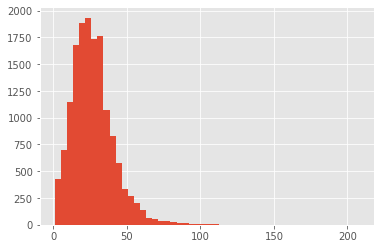

In [55]:
max_len = 150
lstm_n = 256
batch_n = 25
epoch_n = 3

word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}
word2idx['_PAD_'] = 0
word2idx['_OOV_'] = 1

tag2idx = {'O': 0, 'B': 1, 'I': 2}
n_tags = len(tag2idx)

X = [[word2idx.get(m, 1) for m in row[1]] for row in training_data]
y = [[tag2idx.get(m, 0) for m in row[2]] for row in training_data]

# Get an idea about class dist.
cnt = Counter()
for labels in y:
    cnt.update(labels)
cnt_total = sum([v for _, v in cnt.items()])
for k, v in cnt.items():
    print("{0}: {1}".format(k, (100 * v)/cnt_total))
        

# Get a general idea of the lengths of the sequences:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in X], bins=50)
plt.show()

X_test = [[word2idx.get(m, 1) for m in row[1]] for row in simple_data]

X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx['_PAD_'])
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=word2idx['_PAD_'])

In [56]:
pred = model.predict(X_test)
print(pred.shape)
pred_index = np.argmax(pred, axis=-1)
print(pred_index.shape)

(2093, 150, 3)
(2093, 150)


In [62]:
from collections import defaultdict

with open('{0}/simple_eval.eval'.format(simple_home), 'w') as mention_fh:
    for i, row in enumerate(simple_data):
        sent_id = row[0]
        tokens = row[1][:max_len]
        running_count = 0
        buffer = {'s':None, 'e':None, 'text':[]}
        for j, token in enumerate(tokens):
            tag = pred_index[i][j]
            if tag == 1:
                buffer.get('text').append(token)
                buffer['s'] = running_count
                buffer['e'] = running_count + len(token) - 1
            elif tag == 2:
                buffer.get('text').append(token)
                buffer['e'] = running_count + len(token) - 1
            elif tag == 0 and buffer.get('s'):
                text = ' '.join(buffer.get('text'))
                mention_fh.write('{0}|{1} {2}|{3}\n'.format(sent_id, buffer.get('s'), buffer.get('e'), text))
                buffer = {'s':None, 'e':None, 'text':[]}
            running_count += len(token)

In [63]:
file = open('{0}/simple_eval.eval'.format(simple_home), 'r')
lines = file.readlines()

In [64]:
lines

['HY-100006A "MR|44 47|ULK1\n',
 'HY-100006A "MR|51 54|ULK2\n',
 'HY-100015 "Miv|118 119|domain Ki\n',
 'HY-100016 "AZD|30 32|ATM\n',
 'HY-100023 "LY3|9 12|CDC7\n',
 'HY-100023 "LY3|16 20|pMCM2\n',
 'HY-10005 "Flav|48 51|CDKs\n',
 'HY-10005 "Flav|73 76|CDK4\n',
 'HY-10006 "Flav|39 41|CDK\n',
 'HY-10006 "Flav|68 71|CDKs\n',
 'HY-10006 "Flav|91 94|CDK4\n',
 'HY-10008 "SNS-|51 54|CDK9\n',
 'HY-10009 "Sema|10 20|γ - secretase\n',
 'HY-10009 "Sema|39 47|β - amyloid\n',
 'HY-10009 "Sema|118 122|Notch\n',
 'HY-100114 "TA-|19 22|p38 MAPK\n',
 'HY-100114 "TA-|76 78|p38\n',
 'HY-10012 "AZD-|127 130|438 CDK6\n',
 'HY-10013 "Tara|32 43|cannabinoid 1\n',
 'HY-10013 "Tara|144 145|CB1 Ki\n',
 'HY-10014 "R547|469 489|. R547 retinoblastoma protein\n',
 'HY-10015 "PAP-|169 170|1 ]\n',
 'HY-100155 "4-I|52 61|σ1 receptor\n',
 'HY-100155 "4-I|63 64|Ki\n',
 'HY-100155 "4-I|98 107|σ2 receptor\n',
 'HY-100155 "4-I|109 110|Ki\n',
 'HY-100155 "4-I|136 137|Ki\n',
 'HY-100155 "4-I|164 173|Target σ1 receptor\n',
 

In [ ]:
#confidence score for each output
#different IC50 for each drug-protein interaction